In [1]:
import pandas as pd
import seaborn as sns
import pandahouse as db
import matplotlib.pyplot as plt

In [2]:
sns.set(font_scale=2,
        style="darkgrid",
        rc={'figure.figsize': (44,20)})


In [3]:
def get_data(query):

    connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'password': 'dpo_python_2020',
              'user': 'student',
              'database': 'simulator'
             }

    df = db.read_clickhouse(query, connection=connection)
    return df

# Задание1
В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads',
и те, кто пришел через органические каналы source = 'organic'.

Ваша задача — проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей.

In [4]:
q = '''
WITH Table1 AS(
SELECT
    DISTINCT(user_id) as user,
    toDate(time) as date
FROM simulator_20220320.feed_actions
WHERE source = 'ads')

SELECT
    COUNT(Table2.user) as users,
    Table1.date as date
FROM
    (
    SELECT
        user_id as user
    FROM simulator_20220320.feed_actions
    GROUP BY user_id
    HAVING min(toDate(time)) = today() - 30
    ) AS Table2
JOIN Table1
Using user
GROUP BY date
'''

In [5]:
ads_table = get_data(q)

In [6]:
q = '''
WITH Table1 AS(
SELECT
    DISTINCT(user_id) as user,
    toDate(time) as date
FROM simulator_20220320.feed_actions
WHERE source = 'organic')

SELECT
    COUNT(Table2.user) as users,
    Table1.date as date
FROM
    (
    SELECT
        user_id as user
    FROM simulator_20220320.feed_actions
    GROUP BY user_id
    HAVING min(toDate(time)) = today() - 30
    ) AS Table2
JOIN Table1
Using user
GROUP BY date
'''

In [7]:
organic_table = get_data(q)


In [8]:
organic_table['source'] = 'organic'
ads_table['source'] = 'ads'

Посторим два графика и сравним ретеншн

<AxesSubplot:xlabel='date', ylabel='users'>

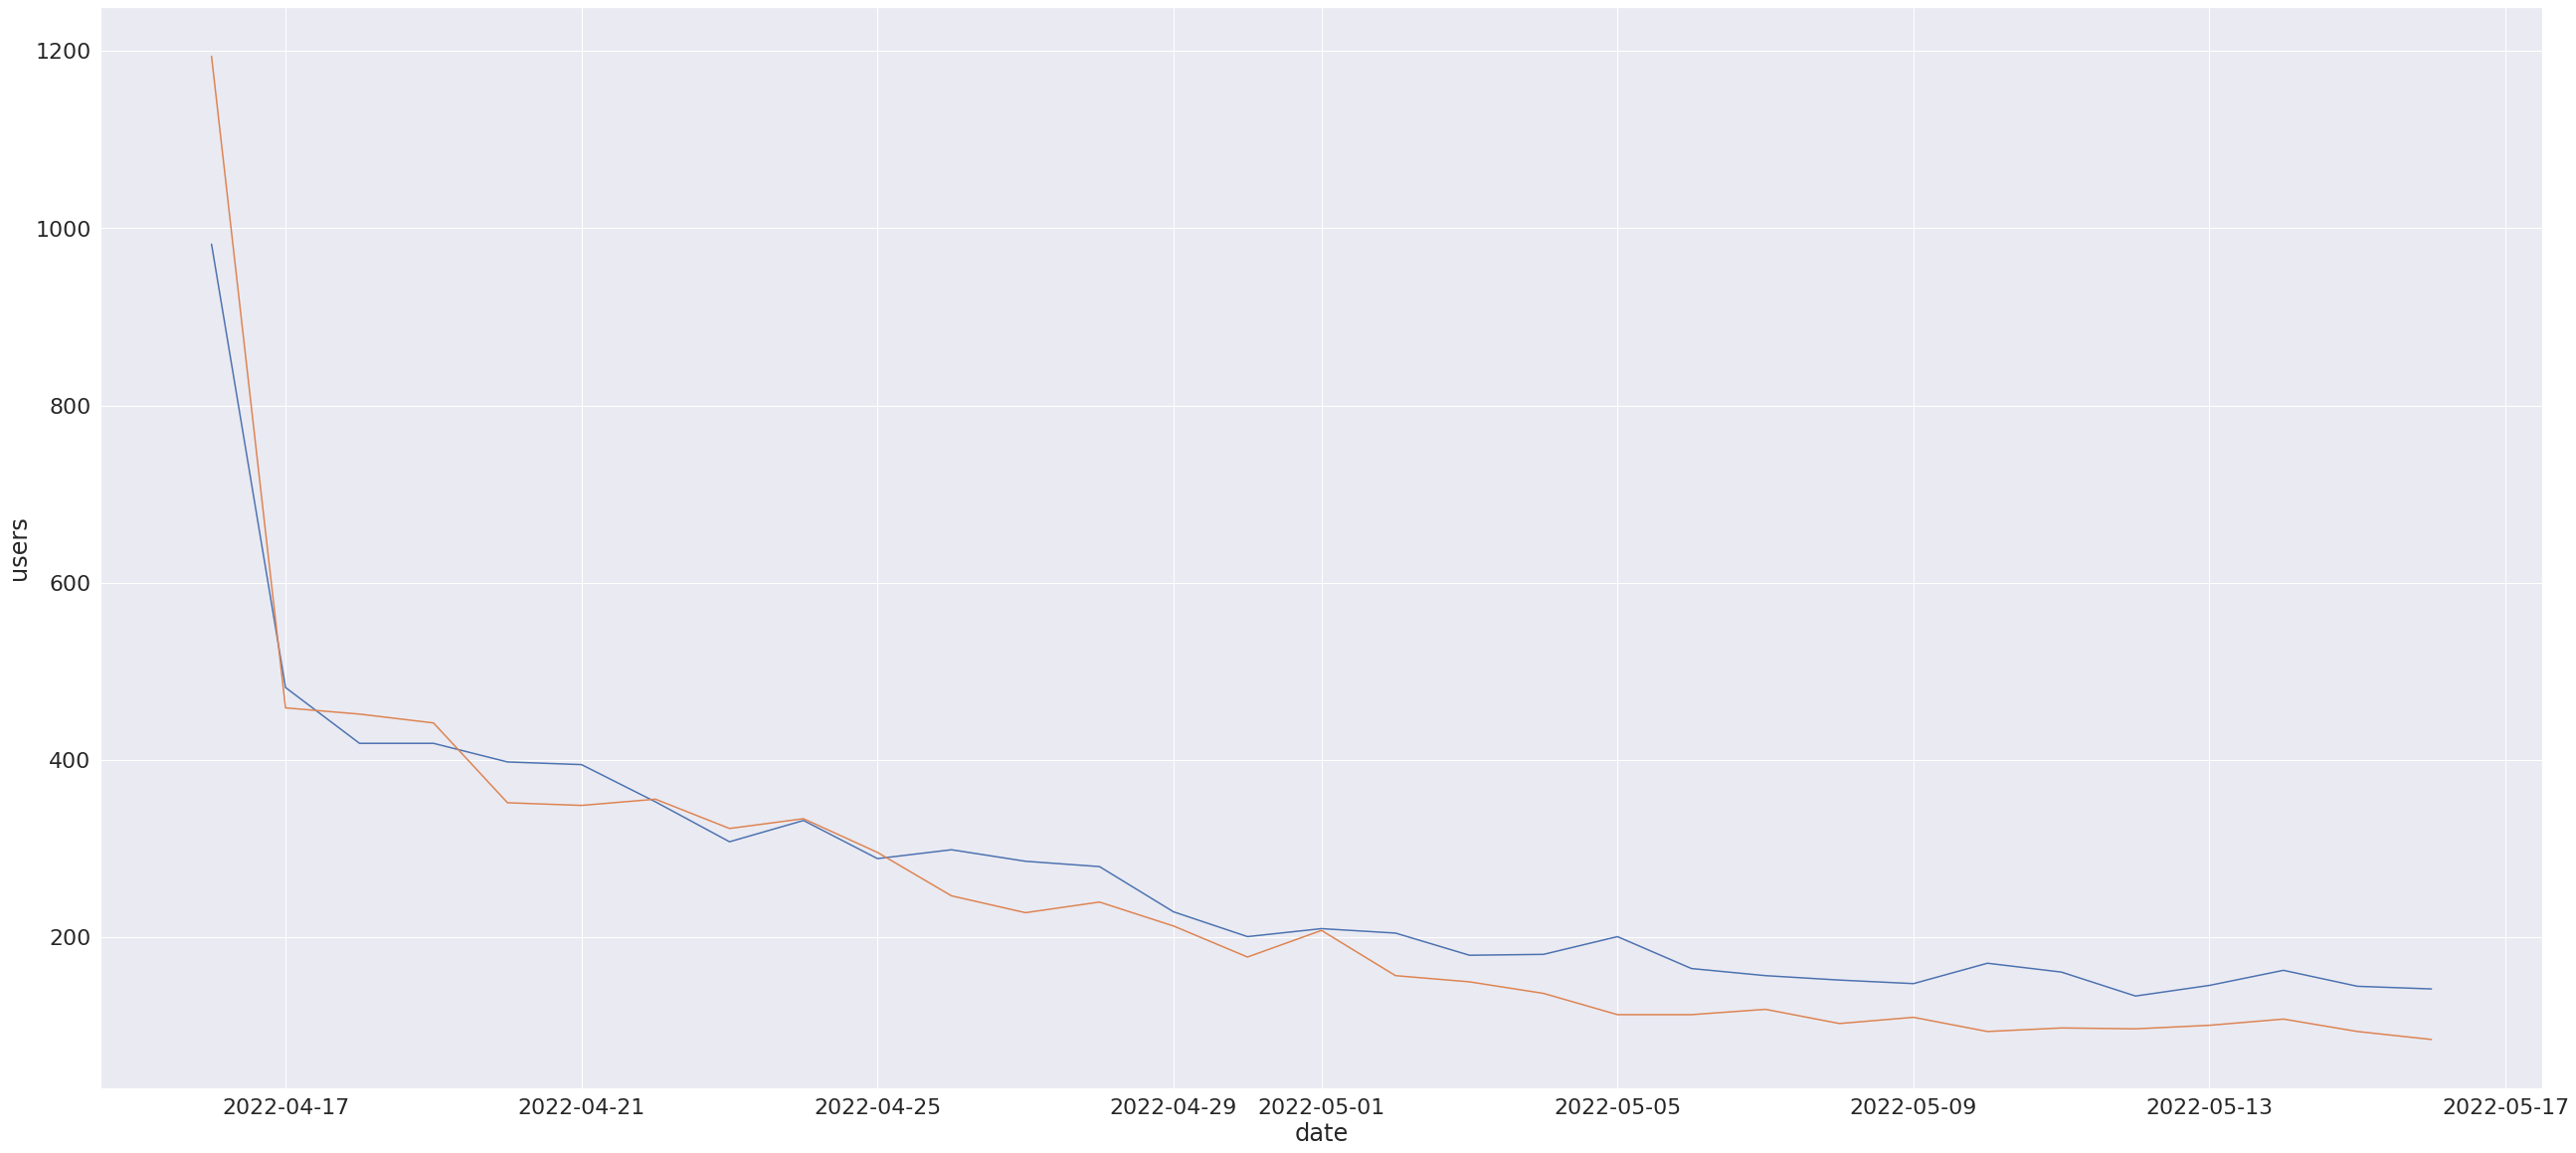

In [9]:
sns.lineplot(x = 'date', y = 'users', data = organic_table)
sns.lineplot(x = 'date', y='users', data = ads_table)

Из графика видно, что ретеншн групп очень значимо отличается, практически в два раза. Это говорит о том, что хоть и на коротком промежутке всплеск был выше у людей, которые пришли с рекламы, мы понимаем, что их сложнее удержать

# Задание2